# Análise e classificação de produtos do marketplace.
### Classificação de produtos pela categoria e distinção de produtos únicos.

Neste notebook exploramos diferentes estratégias de ML/DL para classificar produtos em suas categorias, analisar o desempenho dos classificadores sobre base com milhares de róturos e dinstinguí-los entre suas correspondentes variantes.

In [1]:
import os
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import squareform
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree, ward, complete, centroid, fcluster, average
#from sklearn.cluster import AgglomerativeClustering
from sklearn.base import clone
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

# Módulos locais

from utils.text_clean import clean_text
from utils.word2vec import Word2VecModel
from utils.doc2vec import Doc2VecModel
from utils.fasttext import FastTextModel

from utils.clfs import Clfs

from utils.plots import plot_acc_classes, plot_dists
from utils.evaluation import cluster_accuracy
from utils.tfidf import tfidf

# Warning control
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


In [2]:
headers = ["p_id", "p_title", "vendor_id", "cluster_id", "cluster_title", "cat_id", "cat_title"]
df = pd.read_csv('datasets/pricerunner_aggregate.csv', header=0, names = headers)
#df = df[df.cat_id == 2612]
df.head()

,p_id,p_title,vendor_id,cluster_id,cluster_title,cat_id,cat_title
0,2,apple iphone 8 plus 64 gb spacegrau,2,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
1,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
2,4,apple iphone 8 plus 64gb space grey,4,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
3,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
4,6,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,6,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones


# Construção de atributos (Features)

In [3]:
df = df[ (df.p_title.notna()) & (df.p_title.notnull()) ]

In [4]:
# Atribuindo a cada produto da base um inteiro com a quantidade de nomes
# diferentes estão associados ao seu ID (incluindo ele).
counts = df.cluster_id.value_counts()
freqs = [ counts[cid] for cid in df.cluster_id ]
df["freqs"] = freqs

In [5]:
feat_tokens = clean_text(df.p_title.values)

In [6]:
clean_text(["Olá mundo! São 13:25, dia 31/08 "])

[['olá', 'mundo', 'são', '1325', 'dia', '3108']]

In [8]:
w2v_params = {
    "sentences": feat_tokens,
    "vector_size": 100,
    "sg": 0,
    "window": 5,
    "epochs": 10,
    "workers": 10
}

w2v = Word2VecModel(feat_tokens, params=w2v_params)

d2v_params = {
    "documents":  feat_tokens,
    "vector_size": 100,
    "dm": 0,
    "window": 5,
    "epochs": 10,
    "dbow_words": 1,
    "workers": 10
}

d2v = Doc2VecModel(feat_tokens, params=d2v_params)

fasttext_params = {
    "sentences": feat_tokens,
    "vector_size": 100,
    "sg": 0,
    "window": 5,
    "epochs": 10,
    "workers": 10
}

fasttext = FastTextModel(feat_tokens, params=fasttext_params)

In [10]:
representacoes = {}
representacoes["word2vec"] = w2v.transform(feat_tokens)
representacoes["doc2vec"] = d2v.transform(len(feat_tokens))
representacoes["fasttext"] = fasttext.transform(feat_tokens)
representacoes["tfidf"] = tfidf(df.p_title.values, ngram_range=(1,1), min_df=1)


# Classificação de produtos por categoria.

Verificando o desempenho dos classificadores por categoria.

In [22]:
r = np.random
seed = r.randint(0, 2147483647 * 2)

classifiers = {
    "RandomForestClassifier": RandomForestClassifier(n_jobs=10, random_state=seed),
    "LogisticRegression": LogisticRegression(max_iter=400, multi_class='multinomial', n_jobs=10, random_state=seed),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=seed),
    "KNeighborsClassifier": KNeighborsClassifier(n_jobs=10),
    "SVC": SVC(random_state=seed)
}

classifiers = {
    "RandomForestClassifier": RandomForestClassifier(n_jobs=10, random_state=seed),
    "LogisticRegression": LogisticRegression(max_iter=2000, multi_class='multinomial', n_jobs=10, random_state=seed),
    "KNeighborsClassifier": KNeighborsClassifier(n_jobs=10)
}

"""
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=2000, multi_class='multinomial', n_jobs=10, random_state=seed)
}
"""



'\nclassifiers = {\n    "LogisticRegression": LogisticRegression(max_iter=2000, multi_class=\'multinomial\', n_jobs=10, random_state=seed)\n}\n'

### Avaliando diferentes classificadores para classificação dos produtos em suas categorias.

In [23]:
pipeline = Clfs()

results = []
scores_rep = {}
for rep in representacoes:
    scores_clfs = pipeline.fast_avaliation(classifiers, representacoes[rep], df.cat_id)
    for clf in scores_clfs:
        results.append([rep, clf, scores_clfs[clf]["mean_f1"], scores_clfs[clf]["std_f1"]])

cat_results = pd.DataFrame(results, columns=["Rep", "Clf", "MeanF1", "StdF1"])
timestamp = time.strftime("%Y-%m-%d - %H:%M:%S")
cat_results.to_csv(f'tables/f1_rep_{timestamp}.csv', index=False)
cat_results.head(100)

,Rep,Clf,MeanF1,StdF1
0,word2vec,RandomForestClassifier,0.929085,0.028706
1,word2vec,LogisticRegression,0.920023,0.033956
2,word2vec,KNeighborsClassifier,0.908440,0.027395
3,doc2vec,RandomForestClassifier,0.869612,0.018861
4,doc2vec,LogisticRegression,0.853214,0.026782
5,doc2vec,KNeighborsClassifier,0.865477,0.020503
6,fasttext,RandomForestClassifier,0.946616,0.020767
7,fasttext,LogisticRegression,0.931068,0.030714
8,fasttext,KNeighborsClassifier,0.926282,0.019663
9,tfidf,RandomForestClassifier,0.939762,0.024078


In [26]:
pd.read_csv('tables/f1_rep_2021-09-01 - 09:13:23.csv').head(100)

,Rep,Clf,MeanF1,StdF1
0,word2vec,RandomForestClassifier,0.929085,0.028706
1,word2vec,LogisticRegression,0.920023,0.033956
2,word2vec,KNeighborsClassifier,0.908440,0.027395
3,doc2vec,RandomForestClassifier,0.869612,0.018861
4,doc2vec,LogisticRegression,0.853214,0.026782
5,doc2vec,KNeighborsClassifier,0.865477,0.020503
6,fasttext,RandomForestClassifier,0.946616,0.020767
7,fasttext,LogisticRegression,0.931068,0.030714
8,fasttext,KNeighborsClassifier,0.926282,0.019663
9,tfidf,RandomForestClassifier,0.939762,0.024078


# Verificação dos classificadores para o problema PU.

### Análise do desempenho dos classificadores conforme mais produtos são adicionados a classificação.

In [64]:
pipeline = Clfs()

r = np.random
seed = r.randint(0, 2147483647 * 2)

# Verificando a taxa de acerto pela quantidade de classes.
#n_folds = 5
limit = 30
run_again = True
if run_again:
    results = {}
    for n_class in range(3, 11):
        ids = list(set(df[(df.freqs >= n_class) & (df.cat_id == 2622)].cluster_id))
        results[n_class] = {}
        for i in range(3, limit):
            results[n_class][i] = {}
            # Escolhendo um sample de produtos aleatório da base.
            clusters_ids = np.random.choice(ids, i)
            set_sample = df.cluster_id.isin(clusters_ids)
            # Para cada representação.
            for rep in representacoes:
                target = df[set_sample]["cluster_id"].values
                features = representacoes[rep][set_sample]
                results[n_class][i][rep] = pipeline.fast_avaliation(classifiers, features, target, n_folds=n_class)

    timestamp = time.strftime("%Y-%m-%d - %H:%M:%S")
    with open(f'tables/f1_classes_{timestamp}.json','w') as fd:
        json.dump(results, fd)
else:
    with open('tables/f1_classes_2021-08-31 - 18:49:46.json', 'r') as fd:
        results = json.load(fd)
        plot_acc_classes(results, limit)

# Agrupamento de PUs por categoria

### Para cada categoria inicial da base de dados vamos agrupar os produtos únicos com a técnica de clustering aglomerativo. Utilizamos essa técnica isoladamente por categoria para que essa escale com maior facilidade conforme aumenta o volume dos dados.

In [30]:
cat_ids = set(df.cat_id)

dists = {}
for cat_id in cat_ids:
    indexes = df.cat_id.isin([cat_id])
    feats = representacoes["tfidf"][indexes]
    #feats = tfidf_feats[indexes]
    dist = pairwise_distances(feats, metric="manhattan", n_jobs=10)
    np.fill_diagonal(dist,0)
    dists[cat_id] = squareform(dist)

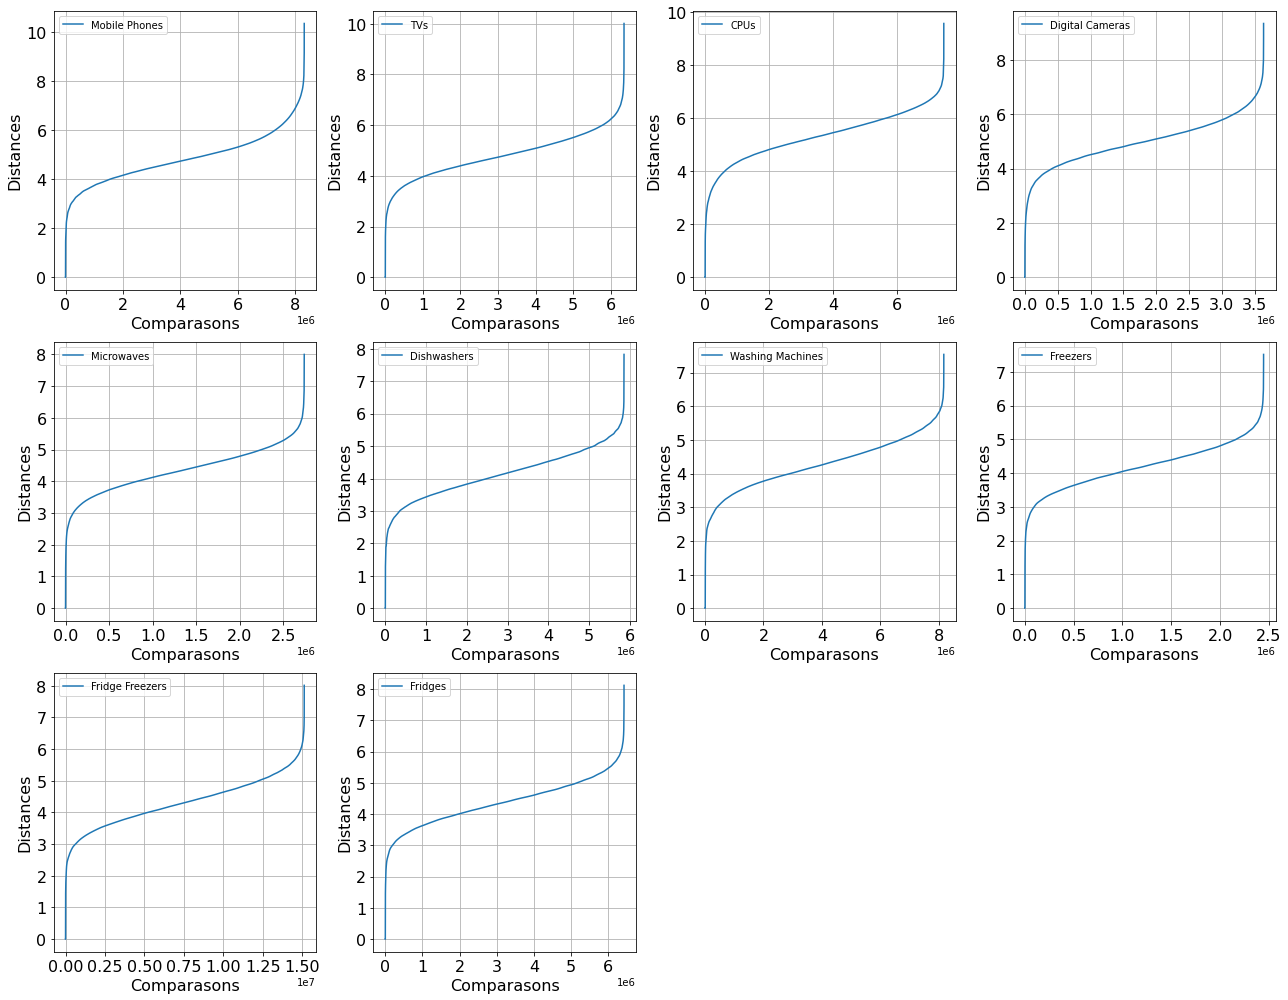

In [31]:
plot_dists(dists, df)

# Buscando altura para corte da árvore de grupos para caga categoria.

### Para isso estamos utilizando o coeficiente de silhoueta como indicador de "qualidade" do cluster.

In [58]:
def cut_search(df, dists, r=None):
    
    pred_labels = {}
    # Para cada categoria.
    for cat_id in dists:
        # Codificando os labels.
        le = preprocessing.LabelEncoder()
        le.fit(df[df.cat_id == cat_id].cluster_id.values)
        targs = le.transform(df[df.cat_id == cat_id].cluster_id.values)
        pred_labels[cat_id] = None
        # Fazendo a busca do ponto de corte.
        print("Cat: ", cat_id)
        # Para cada categoria.
        max_acc = 0
        opt_cut = -1
        max_sil = -1
        matrix = squareform(dists[cat_id])
        for cut_height in np.arange(6.00, 0.00, -0.5):
            #labels = cut_tree(linkage(dists[cat_id]), height=cut_height)
            labels = fcluster(average(dists[cat_id]), t=cut_height, criterion="distance")
            try:
                cof_sil = silhouette_score(matrix, labels, metric="precomputed")
            except:
                cof_sil = -1
            if cof_sil > max_sil:
                max_acc = cluster_accuracy(targs, labels)
                max_sil = cof_sil
                opt_cut = cut_height
                pred_labels[cat_id] = labels
        print("\tCut: ", opt_cut, "Accuracy: ", max_acc, "Silhouette: ", cof_sil)
        print("*"*100)
    return pred_labels


In [59]:
pred_labels = cut_search(df, dists)

Cat:  2612
	Cut:  1.5 Accuracy:  0.7 Silhouette:  0.22210367492185876
****************************************************************************************************
Cat:  2614
	Cut:  2.0 Accuracy:  0.5 Silhouette:  0.17761762995320174
****************************************************************************************************
Cat:  2615
	Cut:  1.5 Accuracy:  0.3333333333333333 Silhouette:  0.3495580072960532
****************************************************************************************************
Cat:  2617
	Cut:  1.5 Accuracy:  0.8181818181818182 Silhouette:  0.27656596095088104
****************************************************************************************************
Cat:  2618
	Cut:  2.0 Accuracy:  0.8333333333333334 Silhouette:  0.20947761561495115
****************************************************************************************************
Cat:  2619
	Cut:  6.0 Accuracy:  0.005552308591466978 Silhouette:  0.21580141356559743
**************

In [60]:
new_df = None
for cat_id in pred_labels:
    temp = df[df.cat_id == cat_id]
    temp["predicted"] = pred_labels[cat_id]
    if new_df is None:
        new_df = temp
    else:
        new_df = pd.concat([new_df, temp])

/tmp/ipykernel_2964396/2412896010.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["predicted"] = pred_labels[cat_id]


In [63]:
cat = new_df[(new_df.cat_id == 2615) & (new_df.cluster_id == 5851)][['p_title','cluster_id','predicted']]
#cat = new_df[(new_df.cat_id == 2615)][['p_title','cluster_id','predicted']]
cat

,p_title,cluster_id,predicted
7644,amd ryzen 7 eight core 1700x 3.80ghz socket am...,5851,319
7645,amd ryzen 7 1700x 8 core am4 cpu/processor,5851,317
7646,amd ryzen 7 1700x 3.4ghz 16mb l3 processor,5851,1174
7647,amd ryzen 7 1700x 95 w 8 core/16 threads 3.8gh...,5851,313
7648,open box amd ryzen 7 1700x 3.8 ghz 8 core 95w ...,5851,314
7649,amd ryzen 7 1700x 8 core 16 thread am4 cpu/pro...,5851,316
7650,wof processor amd ryzen 7 1700x 8 x 3.4 ghz oc...,5851,1369
7651,amd ryzen 7 1700x cpu am4 3.4ghz 3.8 turbo 8 c...,5851,306
7652,amd prozessor cpu ryzen 7 sockel am4 1700x 8 x...,5851,275


In [62]:
print(len(set(new_df.cluster_id)), len(set(new_df.predicted)))

13233 3349
